# 房价数据预测

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

## 数据集

In [2]:
train_data = pd.read_csv('../datasets/house_price/train.csv')
test_data = pd.read_csv('../datasets/house_price/test.csv')

训练数据包含80个特征和1个

In [3]:
train_data.shape

(1460, 81)

In [4]:
train_data.iloc[0:4, [0, 1, 2, 3]]

,Id,MSSubClass,MSZoning,LotFrontage
0,1,60,RL,65.0
1,2,20,RL,80.0
2,3,60,RL,68.0
3,4,70,RL,60.0


In [5]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## **数据预处理**

数据预处理包括:
- 数据的标准化
- 离散数据的数值化
- 缺失值处理

In [6]:
# 获取数值列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 归一化
all_features[numeric_features] = all_features[numeric_features].apply(lambda x :(x - x.mean() / (x.std())))
# 填充缺失值
all_features = all_features.fillna(0)

In [7]:
# 将离散数据数值化(one-hot化)
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)

In [9]:
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view((-1, 1))

## **模型定义**

In [10]:
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [11]:
loss = torch.nn.MSELoss()

比赛采用了对数均方根误差      
$\sqrt {\frac 1n \sum_{i=1}^{n}(log(y_i)-log(\hat y_i))^2}$

In [12]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 在计算log时，最好能把小于1的值设置成1，这样取对数时更加稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

## ** 训练模型 **

In [37]:
def train(net, train_feature, train_label, test_feature,test_label, num_epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_feature, train_label)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X.float())
            l = loss(y_hat, y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_l = log_rmse(net, train_features, train_labels)
        train_ls.append(train_l)
        if test_label is not None:
            test_ls.append(log_rmse(net, test_feature, test_label))
    return train_ls, test_ls

In [38]:
# K折交叉
from sklearn.model_selection import KFold


def kfold(X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    X_numpy = X.numpy()
    y_numpy = y.numpy()
    for train_index, test_index in kf.split(X_numpy, y_numpy):
        yield (torch.tensor(X_numpy[train_index], dtype=torch.float)
        , torch.tensor(y_numpy[train_index], dtype=torch.float)
        , torch.tensor(X_numpy[test_index], dtype=torch.float)
        , torch.tensor(y_numpy[test_index], dtype=torch.float))

In [39]:
def k_fold(train_data, train_labels, num_epochs, lr, weight_decay, batch_size):
    train_l_sum, test_l_sum = 0.0, 0.0
    i = 0
    for data in kfold(train_data, train_labels):
        net = get_net(train_data.shape[-1])
        train_ls, test_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        test_l_sum += test_ls[-1]
        print('fold{:d}: train rmse {:.4f} val rmse {:.4f}'.format(i, train_ls[-1], test_ls[-1]))
    return train_l_sum / 5, test_l_sum / 5

In [44]:
train_loss , test_loss = k_fold(train_features, train_labels, 100, 3, 0.5, 64)

fold0: train rmse 0.2618 val rmse 0.2740
fold0: train rmse 0.2392 val rmse 0.2875
fold0: train rmse 0.3312 val rmse 0.3223
fold0: train rmse 0.2550 val rmse 0.2623
fold0: train rmse 0.2971 val rmse 0.2811


## **生成提交文件**

In [55]:
net = get_net(train_features.shape[-1])
train_ls, _ = train(net, train_features, train_labels, None, None, 100, 5, 0.5, 256)
preds = net(test_features).detach().numpy()
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)

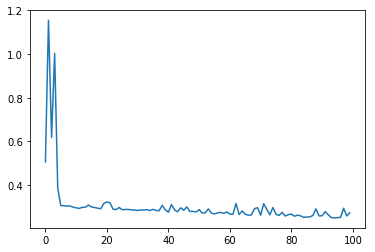

In [57]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_ls)), train_ls)
plt.show()

In [58]:
submission.to_csv('../submission/submission.csv', index=False)